In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 3
### 1.
suppose that the probabilities that a neuron responds with a firing rate between $r$ and $r + \Delta r$ to two stimuli labeled plus and minus are $p[r|\pm]\Delta r$ where

$p[r|\pm] = \frac{1}{\sqrt{2\pi\sigma}} \exp (-\frac{1}{2}(\frac{r - \langle{r}\rangle{}_\pm}{\sigma_r})^2)$

Assume that the two mean rate parameters $\langle{r}\rangle{}_+$ and $\langle{r}\rangle{}_-$ and the single variance $\sigma_r^2$ are chosen so that these distributions produce negative rates rarely enough that we can integrate over $r$ values over the entire range $-\infty \lt r \lt \infty$. Suppose that you base discrimination of the plus and minus stimuli on whether the evoked firing rate is greater or less than a threshold $z$. Show that the size and power, $\alpha(z)$ and $\beta(z)$ of this test are given by 

$\alpha(z) = \frac{1}{2}\text{erfc}(\frac{z - \langle{r}\rangle{}_-}{\sqrt{2\sigma}_r})$ and $\beta(z) = \frac{1}{2}\text{erfc}(\frac{z - \langle{r}\rangle{}_+}{\sqrt{2\sigma}_r})$

By simulation, determine the fraction of correct discriminations that can be made in the two-alternative forced choice task. show that the fractions of correct answer for different values of $d'$ are equal to the areas under the corresponding ROC curves

In [8]:
from scipy.special import erfc
from scipy.stats import norm

# define functions

def p(r, mean, sigma):
    return 1 / (np.sqrt(2*sigma*np.pi)) * np.exp(-0.5 * ((r - mean) / sigma)**2)

def alpha(z, mean_minus, sigma):
    return 0.5 * erfc((z - mean_minus) / (np.sqrt(2) * sigma))

def beta(z, mean_plus, sigma):
    return 0.5 * erfc((z - mean_plus) / (np.sqrt(2) * sigma))

def d_prime(mean_plus, mean_minus, sigma):
    return (mean_plus - mean_minus) / sigma

def sim_2afc(mean_plus, mean_minus, sigma, n_trials=10000):
    r_plus = np.random.normal(mean_plus, sigma, n_trials)
    r_minus = np.random.normal(mean_minus, sigma, n_trials)
    return np.mean(r_plus > r_minus)

In [17]:
# run simulation
mean_minus = 5
mean_plus = 6
sigma = 2

d_prime_val = d_prime(mean_plus, mean_minus, sigma)
fraction_correct = sim_2afc(mean_plus, mean_minus, sigma)

print(f"d' = {d_prime_val:.4f}")
print(f"Fraction correct (simulated) = {fraction_correct:.4f}")
print(f"Theoretical fraction correct = {0.5 * erfc(-d_prime_val / 2):.4f}")

d' = 0.5000
Fraction correct (simulated) = 0.6361
Theoretical fraction correct = 0.6382


d' = 0.50:
  Fraction correct (simulated) = 0.6295
  Area under ROC curve = -0.6146
d' = 1.00:
  Fraction correct (simulated) = 0.7629
  Area under ROC curve = -0.7353
d' = 1.50:
  Fraction correct (simulated) = 0.8573
  Area under ROC curve = -0.8282
d' = 2.00:
  Fraction correct (simulated) = 0.9229
  Area under ROC curve = -0.8903
d' = 2.50:
  Fraction correct (simulated) = 0.9607
  Area under ROC curve = -0.9262


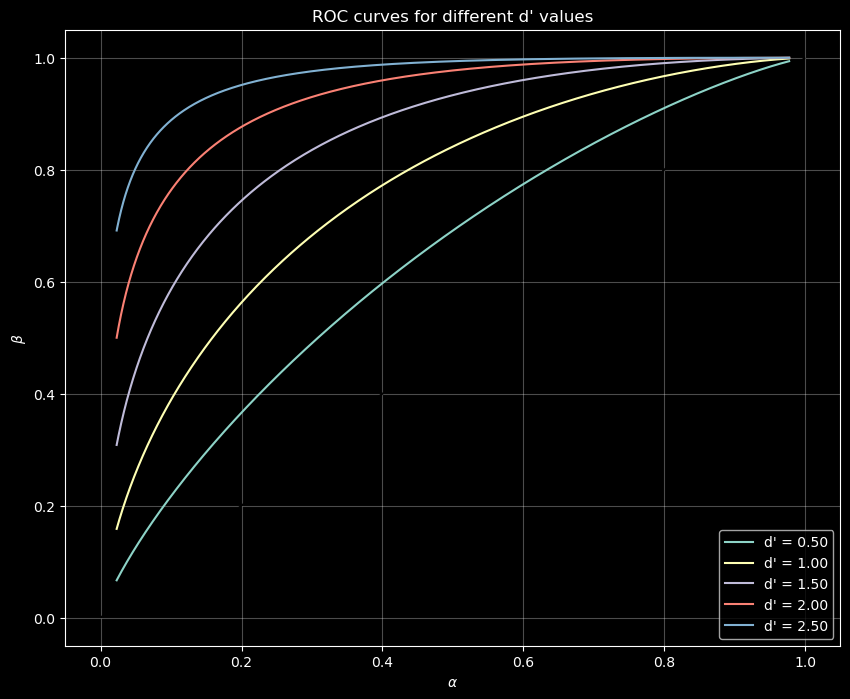

In [26]:
def plot_roc_curves(d_prime_val_list):
    z = np.linspace(-4, 4, 1000)
    plt.figure(figsize=(10, 8))

    for val in d_prime_val_list:
        mean_plus = val * sigma
        mean_minus = 0

        alpha_vals = alpha(z, mean_minus, sigma)
        beta_vals = beta(z, mean_plus, sigma)
        
        plt.plot(alpha_vals, beta_vals, label=f'd\' = {val:.2f}')

        # simulate again and calculate area under ROC
        fraction_correct = sim_2afc(mean_plus, mean_minus, sigma)
        area_under_roc = np.trapz(beta_vals, alpha_vals)

        print(f"d' = {val:.2f}:")
        print(f"  Fraction correct (simulated) = {fraction_correct:.4f}")
        print(f"  Area under ROC curve = {area_under_roc:.4f}")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('$\\alpha$')
    plt.ylabel('$\\beta$')
    plt.title('ROC curves for different d\' values')
    plt.legend()
    plt.grid(which='both', alpha=0.3)
    plt.show()

d_prime_values = [0.5, 1, 1.5, 2, 2.5]
plot_roc_curves(d_prime_values)

### 2.
simulate the random-dot discrimination experiment. denote the stimulus by plus or minus, corresponding to the two directions of motion. on each trial, choose the stimulus randomly with equal probability for the two cases. 
- when the minus stimulus is chosen, generate the responses of the neuron as 20Hz plus a random gaussian term with a standard deviation of 10Hz (set any rates that come out negative to 0).
- when the plus stimulus is chosen, generate the responses as 20 + 10$d$ Hz plus a random gaussian term with a standard deviation of 10Hz, where $d$ is the discriminability (set any rates that come out negative to 0).
- first, choose a threshold $z = 20 +5d$, which is halfway between the means of te two response distributions. whenever $r \ge z$ guess "plus", otherwise guess "minus". over  large number of trials (1000, eg) determine how often you get the right answer for different $d$ values. plot the percent correct as a function of $d$ over the range $0 \le d \le 10$
- next, by allowing $z$ to vary over a range, plot ROC curves for several values of $d$ (starting with $d=2$). to do this, determine how frequently the guess is "plus" when the stimulus is, in fact, plus (this is $\beta$, true positive), and how often the guess is "plus" when the real stimulus is minus (this is $\alpha$, false positive)
- plot $\beta$ versus $\alpha$ for $z$ over the range $0 \le z \le 140$

In [30]:
def generate_response(stim, d, sigma=10):
    if stim == 'minus':
        rate = 20 + np.random.normal(0, sigma)
    elif stim == 'plus':
        rate = 20 + 10*d + np.random.normal(0, sigma)
    return max(rate, 0)  # set negative rate to 0

def simulate_experiment(d, z, n_trials=1000):
    correct_count = 0
    plus_count = 0
    plus_correct = 0
    minus_count = 0
    minus_correct = 0

    for _ in range(n_trials):
        stimulus = np.random.choice(['plus', 'minus'])
        response = generate_response(stimulus, d)
        guess = 'plus' if response >= z else 'minus'

        if stimulus == guess:
            correct_count += 1

        if stimulus == 'plus':
            plus_count += 1
            if guess == 'plus':
                plus_correct += 1

        if stimulus == 'minus':
            minus_count += 1
            if guess == 'minus':
                minus_correct += 1

    percent_correct = (correct_count / n_trials) * 100
    beta = plus_correct / plus_count if plus_count > 0 else 0
    alpha = 1 - (minus_correct / minus_count) if minus_count > 0 else 0

    return percent_correct, alpha, beta

In [33]:
d_vals = np.linspace(0, 10, 21)
percent_correct_vals = []

for d in d_vals:
    z = 20 + 5*d
    percent_correct, _, _ = simulate_experiment(d, z)
    percent_correct_vals.append(percent_correct)

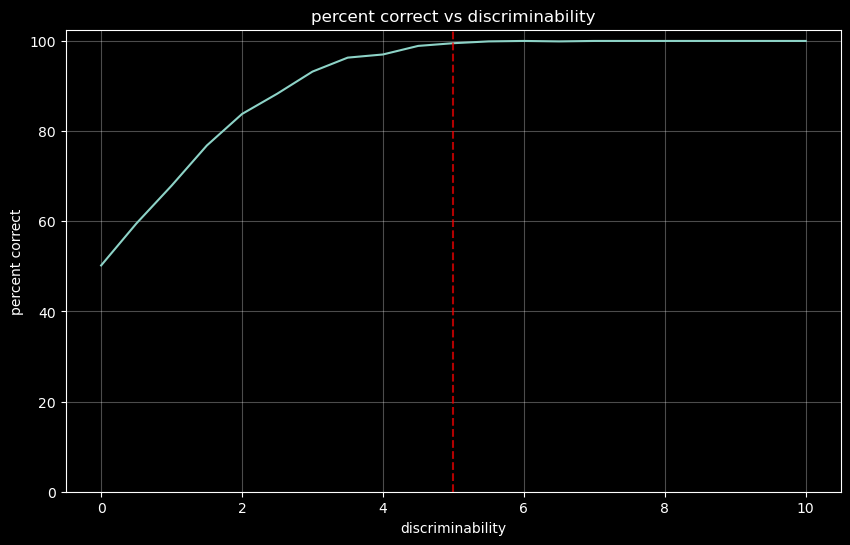

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(d_vals, percent_correct_vals)
ax.set_xlabel('discriminability')
ax.set_ylabel('percent correct')
ax.set_title('percent correct vs discriminability')
ax.grid(which='both', alpha=0.3)
ax.set_ylim(0)
ax.axvline(5, color='red', alpha=0.7, linestyle='--')  # percent correct reaches 100% at d=0.5

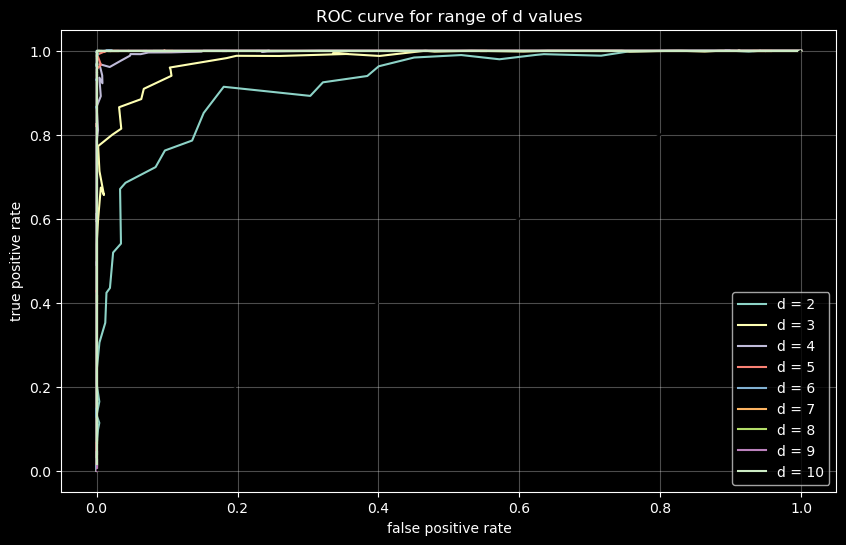

In [53]:
d_vals = np.arange(2, 11, 1)
z_vals = np.linspace(0, 140, 100)

fig, ax = plt.subplots(figsize=(10, 6))

for d in d_vals:
    alpha_vals = []
    beta_vals = []
    for z in z_vals:
        _, alpha, beta = simulate_experiment(d, z)
        alpha_vals.append(alpha)
        beta_vals.append(beta)
    ax.plot(alpha_vals, beta_vals, label=f'd = {d}')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('ROC curve for range of d values')
ax.legend()
ax.grid(which='both', alpha=0.3)

### 3. simulate the responses of four interneurons in the cercal system of the cricket and check the accuracy of a vector decoding scheme

for a true wind direction $\theta$, the average firing rates of thefour interneurons should be generated as 

$\langle{r_i}\rangle{} = [50 \text{Hz}\cos(\theta - \theta_i)]_+$

where $[]_+$ indicates half-wave rectification, and $\theta_i = \pi/4, 3\pi/4, 5\pi/4, 7\pi/4$ for $i = 1,2,3,4$

the actual rates, $r_i$, are then obtained by adding to these mean rates a random number chosen from a Gausssian distribution with zero mean and standard deviation of 5Hz (set any rates that come out negative to 0). 

from these rates, construct the $x$ and $y$ components of the population vector

$ x =  \sum_{i=1}^{4}r_i \cos(\theta_i) $ and $ y =  \sum_{i=1}^{4}r_i \sin(\theta_i)$

and, from the direction of this vector, compute an estimate $\theta_{\text{est}}$ of the wind direction. average the squared difference $(\theta - \theta_{\text{est}})^2$ over 1000 trials. the square root of this quantity is the error. plot the error as a function of $\theta$ over the range $-90^\circ \le \theta \le 90^\circ$

(0.0, 7.76008702467399)

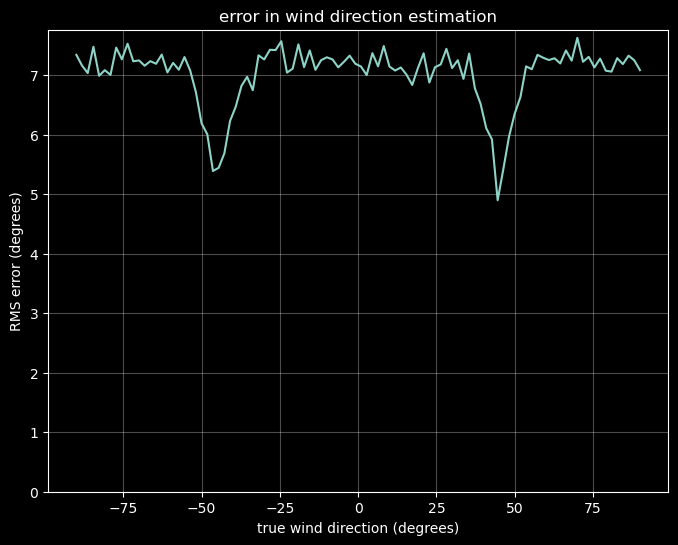

In [58]:
def generate_response(theta, theta_i, sigma=5):
    mean_rate = 50 * np.cos(theta - theta_i)
    mean_rate = max(mean_rate, 0)  # half-wave rectif
    rate = mean_rate + np.random.normal(0, sigma)
    return max(rate, 0) # ensure non-negative rate

def estimate_direction(rates, theta_i):
    x = np.sum(rates * np.cos(theta_i))
    y = np.sum(rates * np.sin(theta_i))
    return np.arctan2(y, x)

def run_simulation(true_theta, n_trials=1000):
    theta_i = np.array([np.pi/4, 3*np.pi/4, 5*np.pi/4, 7*np.pi/4])
    squared_errors = []

    for _ in range(n_trials):
        rates = [generate_response(true_theta, ti) for ti in theta_i]
        theta_est = estimate_direction(rates, theta_i)
        error = (true_theta - theta_est) % (2*np.pi)
        error = min(error, 2*np.pi - error)
        squared_errors.append(error**2)

    return np.sqrt(np.mean(squared_errors))

theta_range = np.linspace(-np.pi/2, np.pi/2, 100)
errors = [run_simulation(theta) for theta in theta_range]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.degrees(theta_range), np.degrees(errors))
ax.set_xlabel('true wind direction (degrees)')
ax.set_ylabel('RMS error (degrees)')
ax.set_title('error in wind direction estimation')
ax.grid(which='both', alpha=0.3)
ax.set_ylim(0)